In [9]:
import gensim.downloader as api

info_datasets = api.info()
print(info_datasets)
dataset_info = api.info("text8")
dataset = api.load("text8")
word2vec_model = api.load('word2vec-google-news-300')

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1, 'record_format': 'dict', 'file_size': 6344358, 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py', 'license': 'All files released for the task are free for general research use', 'fields': {'2016-train': ['...'], '2016-dev': ['...'], '2017-test': ['...'], '2016-test': ['...']}, 'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.', 'checksum': '701ea67acd82e75f95e1d8e62fb0ad29', 'file_name': 'semeval-2016-2017-task3-subtaskBC.gz',

In [11]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('data/development.csv')
print(f"Dataset shape: {df.shape}")
print(f"Labels distribution:\n{df['label'].value_counts().sort_index()}")

Dataset shape: (79997, 7)
Labels distribution:
label
0    23542
1    10588
2    11161
3     9977
4     8574
5    13053
6     3102
Name: count, dtype: int64


In [12]:
# Preprocessing: combine source + article, compute article length
def preprocess_text(text):
    """Tokenize and clean text for Word2Vec."""
    if pd.isna(text):
        return []
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    tokens = word_tokenize(text)
    return [t for t in tokens if len(t) > 1]

def document_to_vector(tokens, model, dim=300):
    """Convert tokens to averaged Word2Vec vector."""
    vectors = [model[word] for word in tokens if word in model]
    if len(vectors) == 0:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

# Combine source + article into single text
df['combined_text'] = df['source'].fillna('') + ' ' + df['article'].fillna('')

# Calculate article length (number of characters)
df['article_length'] = df['article'].fillna('').apply(len)

# Tokenize combined text
df['tokens'] = df['combined_text'].apply(preprocess_text)

print(f"Sample combined text tokens: {df['tokens'].iloc[0][:10]}")
print(f"Article length stats:\n{df['article_length'].describe()}")

Sample combined text tokens: ['AllAfricacom', 'THE', 'Organisation', 'of', 'Petroleum', 'Exporting', 'Countries', 'OPEC', 'is', 'hiking']
Article length stats:
count    79997.000000
mean       273.152431
std        352.797158
min          0.000000
25%        140.000000
50%        192.000000
75%        239.000000
max      15790.000000
Name: article_length, dtype: float64


In [13]:
# Create Word2Vec features (this may take a few minutes)
print("Creating Word2Vec features...")
w2v_features = np.array([document_to_vector(tokens, word2vec_model) for tokens in df['tokens']])
print(f"Word2Vec features shape: {w2v_features.shape}")

# Create feature DataFrame
feature_cols = [f'w2v_{i}' for i in range(300)]
df_features = pd.DataFrame(w2v_features, columns=feature_cols)

# Add additional features: page_rank and article_length
df_features['page_rank'] = df['page_rank'].values
df_features['article_length'] = df['article_length'].values

# Add label
df_features['label'] = df['label'].values

print(f"\nFinal feature DataFrame shape: {df_features.shape}")
print(f"Features: 300 Word2Vec + page_rank + article_length = 302 features")

Creating Word2Vec features...
Word2Vec features shape: (79997, 300)

Final feature DataFrame shape: (79997, 303)
Features: 300 Word2Vec + page_rank + article_length = 302 features


In [14]:
# Prepare train/test split
feature_columns = [f'w2v_{i}' for i in range(300)] + ['page_rank', 'article_length']

X = df_features[feature_columns].values
y = df_features['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} samples ({c/len(y_train)*100:.1f}%)")

Training set: (63997, 302)
Test set: (16000, 302)

Class distribution in training set:
  Class 0: 18833 samples (29.4%)
  Class 1: 8470 samples (13.2%)
  Class 2: 8929 samples (14.0%)
  Class 3: 7982 samples (12.5%)
  Class 4: 6859 samples (10.7%)
  Class 5: 10442 samples (16.3%)
  Class 6: 2482 samples (3.9%)


In [22]:
df_features

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_293,w2v_294,w2v_295,w2v_296,w2v_297,w2v_298,w2v_299,page_rank,article_length,label
0,-0.051836,-0.048139,0.030015,0.111694,-0.020333,0.022899,-0.000246,-0.144032,0.123156,0.072310,...,0.013595,-0.000872,0.039492,0.004920,-0.021810,0.075248,-0.042707,5,214,5
1,0.042357,0.076288,0.063891,0.052133,0.020832,-0.113467,0.013796,-0.105764,0.064365,0.110601,...,-0.007530,-0.081469,0.034470,0.002117,-0.031305,0.078247,0.048781,5,161,0
2,0.020907,0.030340,-0.010693,0.022942,-0.013704,-0.029825,0.017603,-0.107817,0.061113,0.078530,...,0.064725,0.032874,-0.073331,0.041802,-0.000987,0.053210,-0.019492,5,181,0
3,0.009845,0.044366,0.020132,0.098931,-0.079015,0.071907,0.115882,-0.029311,0.050152,0.012264,...,0.062791,-0.000725,0.006717,0.002808,0.012054,0.009719,0.013880,5,111,0
4,0.072111,0.037341,0.026389,0.014615,-0.007018,-0.051382,0.029892,-0.135261,0.064136,0.077251,...,0.062379,-0.024159,-0.013483,-0.053783,-0.010955,0.034984,-0.082547,5,720,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79992,0.045175,0.051689,0.031074,-0.011426,-0.050746,-0.109557,0.031637,-0.125099,0.120006,0.051963,...,-0.001021,-0.024311,0.033695,-0.039589,-0.048278,0.024798,-0.008668,5,792,0
79993,0.020102,0.041610,0.027779,-0.002321,-0.059393,-0.082464,0.004811,-0.059330,0.089322,0.036369,...,0.019563,-0.014014,0.020820,-0.014706,-0.042130,0.030931,-0.077238,5,206,4
79994,0.048845,0.038814,0.032494,-0.009840,-0.048471,-0.080607,-0.009435,-0.134463,0.088079,0.078876,...,0.036961,-0.018270,0.016557,-0.046378,-0.064899,0.039011,0.017128,5,204,0
79995,-0.018244,0.081230,0.090027,-0.008750,-0.023368,-0.013653,-0.001927,-0.000517,0.053881,0.057495,...,0.026267,-0.019674,-0.041431,0.006277,-0.012643,-0.007383,0.077565,5,192,3


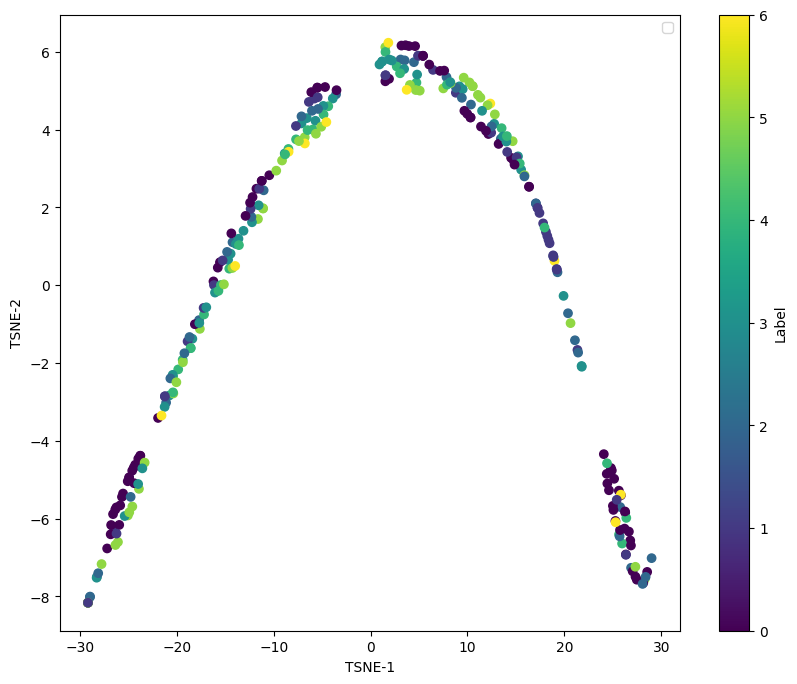

In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Riduciamo il numero di campioni per accelerare il calcolo
sampled_df = df_features.sample(n=1000, random_state=42)

sampled_df = sampled_df[0:300]

# Selezioniamo solo le colonne numeriche
df_features_numeric = sampled_df.select_dtypes(include=['float64', 'int64'])

# Applichiamo t-SNE per ridurre la dimensionalità a 3D
tsne = TSNE(n_components=2, random_state=42)
df_features_tsne = tsne.fit_transform(df_features_numeric)

# Creiamo il grafico 3D usando solo matplotlib
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Visualizziamo il grafico, colorando i punti in base alla label
scatter = ax.scatter(df_features_tsne[:, 0], df_features_tsne[:, 1],
                     c=sampled_df['label'])

# Aggiungiamo etichette e una barra dei colori
ax.set_xlabel('TSNE-1')
ax.set_ylabel('TSNE-2')
ax.legend()
fig.colorbar(scatter, ax=ax, label='Label')


plt.show()

In [19]:
# Build Pipeline with StandardScaler + Classifier
from sklearn.metrics import f1_score
from sklearn.ensemble import HistGradientBoostingClassifier

from imblearn.ensemble import BalancedBaggingClassifier

# Define base pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', BalancedBaggingClassifier(
        estimator=HistGradientBoostingClassifier(random_state=42),
        n_estimators=10,
        random_state=42,
        n_jobs=2))
])

# Quick baseline evaluation
print("Baseline evaluation with default RandomForest...")
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"Baseline Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Baseline Macro F1: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

Baseline evaluation with default RandomForest...
Baseline Accuracy: 0.6657
Baseline Macro F1: 0.6672

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.62      0.66      4709
           1       0.68      0.78      0.73      2118
           2       0.78      0.79      0.78      2232
           3       0.54      0.53      0.53      1995
           4       0.76      0.91      0.83      1715
           5       0.53      0.46      0.49      2611
           6       0.52      0.82      0.64       620

    accuracy                           0.67     16000
   macro avg       0.65      0.70      0.67     16000
weighted avg       0.67      0.67      0.66     16000



In [20]:
# Hyperparameter tuning with GridSearchCV
# Using Macro F1 as scoring metric

param_grid = [
    # Logistic Regression
    {
        'classifier': [LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__solver': ['lbfgs', 'saga'],
    }
]

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Starting GridSearchCV with Macro F1 scoring...")
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='f1_macro',  # Macro F1 score
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

Starting GridSearchCV with Macro F1 scoring...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'classifier': [LogisticRegre...ndom_state=42)], 'classifier__C': [0.1, 1.0, ...], 'classifier__solver': ['lbfgs', 'saga']}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1_macro'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computa

In [ ]:
# Display GridSearchCV results
print("=" * 60)
print("HYPERPARAMETER TUNING RESULTS (Macro F1)")
print("=" * 60)

print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Macro F1: {grid_search.best_score_:.4f}")

# Results DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')
print(f"\nTop 5 Configurations:")
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head())

In [ ]:
# Final evaluation on test set with best model
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("=" * 60)
print("FINAL EVALUATION ON TEST SET")
print("=" * 60)

best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)

print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Test Macro F1: {f1_score(y_test, y_pred_final, average='macro'):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_final))

# Label mapping for reference
label_names = {
    0: 'International News',
    1: 'Business',
    2: 'Technology',
    3: 'Entertainment',
    4: 'Sports',
    5: 'General News',
    6: 'Health'
}
print("\nLabel Reference:")
for k, v in label_names.items():
    print(f"  {k}: {v}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names.values(),
            yticklabels=label_names.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Save the best model for later use
import joblib

joblib.dump(best_model, 'model/best_classifier.joblib')
joblib.dump(word2vec_model, 'model/word2vec_model.joblib')

print("Models saved to 'model/' directory")
print(f"  - best_classifier.joblib")
print(f"  - word2vec_model.joblib")